In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load data from .sqlite file

In [2]:
# Connect to the SQLite database
conn = sqlite3.connect('wildfires.sqlite')

# Create a cursor object
cursor = conn.cursor()

# Fetch the table names from the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
table_names = cursor.fetchall()

# Select the first table name
table_name = table_names[21][0]  # Assuming there is at least one table in the database

In [3]:
# Execute a query to fetch data from the selected table
cursor.execute(f"SELECT * FROM {table_name}")

# Fetch all the results and store them as a list of tuples
data = cursor.fetchall()

# Get column names from cursor description
columns = [col[0] for col in cursor.description]

# Close the cursor and the connection
cursor.close()
conn.close()

# Create a DataFrame from the fetched data
df_all_cols = pd.DataFrame(data, columns=columns)

In [4]:
df = df_all_cols[['FOD_ID','FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'STATE', 'FIRE_NAME', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'FIRE_YEAR', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE', 'FIRE_SIZE']]
df.head()

,FOD_ID,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,FIRE_NAME,DISCOVERY_DATE,DISCOVERY_DOY,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,FIRE_SIZE
0,1,A,40.036944,-121.005833,CA,FOUNTAIN,2453403.5,33,2005,9.0,Miscellaneous,2453403.5,0.10
1,2,A,38.933056,-120.404444,CA,PIGEON,2453137.5,133,2004,1.0,Lightning,2453137.5,0.25
2,3,A,38.984167,-120.735556,CA,SLACK,2453156.5,152,2004,5.0,Debris Burning,2453156.5,0.10
3,4,A,38.559167,-119.913333,CA,DEER,2453184.5,180,2004,1.0,Lightning,2453189.5,0.10
4,5,A,38.559167,-119.933056,CA,STEVENOT,2453184.5,180,2004,1.0,Lightning,2453189.5,0.10


#### Outline of what the code below achieves

* Plotting change in frequency of wildfires over time
    - Compare this within different regions/seasons
    - Perform a hypothesis test to determine if some regions have different peak times and different frequencies, also to determine maximum confidence by which we can say that wildfires have increased in frequency

### Filter fires by region, season, and region+season

In [5]:
northeast = ['ME', 'NH', 'VT', 'MA', 'RI', 'CT', 'NY', 'NJ', 'PA']
midwest = ['OH', 'MI', 'IN', 'WI', 'IL', 'MN', 'IO', 'MO', 'ND', 'SD', 'NE', 'KS']
south = ['DE', 'MD', 'VI', 'WV', 'KY', 'NC', 'SC', 'TN', 'GA', 'FL', 'AL', 'MS', 'AR', 'LA', 'TX', 'OK']
west = ['MT', 'ID', 'WY', 'CO', 'NM', 'AZ', 'UT', 'NV', 'CA', 'OR', 'WA']
#from US Census Bureau: https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf
#exclues AK + HI for simiplicity

#winter = days 354-365 + 0-78
#spring = days 79-170
#summer = days 171-262
#fall = days 263-353

In [29]:
northeast_df = df[df['STATE'].isin(northeast)]
midwest_df = df[df['STATE'].isin(midwest)]
south_df = df[df['STATE'].isin(south)]
west_df = df[df['STATE'].isin(west)]

In [30]:
winter = df[(df.get('DISCOVERY_DOY') >= 354) | (df.get('DISCOVERY_DOY') <= 78)]
spring = df[(df.get('DISCOVERY_DOY') >= 79) & (df.get('DISCOVERY_DOY') <= 170)]
summer = df[(df.get('DISCOVERY_DOY') >= 171) & (df.get('DISCOVERY_DOY') <= 262)]
fall = df[(df.get('DISCOVERY_DOY') >= 263) & (df.get('DISCOVERY_DOY') <= 353)]

In [31]:
winter_ne = northeast_df[(northeast_df.get('DISCOVERY_DOY') >= 354) | (northeast_df.get('DISCOVERY_DOY') <= 78)]
spring_ne = northeast_df[(northeast_df.get('DISCOVERY_DOY') >= 79) & (northeast_df.get('DISCOVERY_DOY') <= 170)]
summer_ne = northeast_df[(northeast_df.get('DISCOVERY_DOY') >= 171) & (northeast_df.get('DISCOVERY_DOY') <= 262)]
fall_ne = northeast_df[(northeast_df.get('DISCOVERY_DOY') >= 263) & (northeast_df.get('DISCOVERY_DOY') <= 353)]

In [32]:
winter_mw = midwest_df[(midwest_df.get('DISCOVERY_DOY') >= 354) | (midwest_df.get('DISCOVERY_DOY') <= 78)]
spring_mw = midwest_df[(midwest_df.get('DISCOVERY_DOY') >= 79) & (midwest_df.get('DISCOVERY_DOY') <= 170)]
summer_mw = midwest_df[(midwest_df.get('DISCOVERY_DOY') >= 171) & (midwest_df.get('DISCOVERY_DOY') <= 262)]
fall_mw = midwest_df[(midwest_df.get('DISCOVERY_DOY') >= 263) & (midwest_df.get('DISCOVERY_DOY') <= 353)]

In [33]:
winter_s = south_df[(south_df.get('DISCOVERY_DOY') >= 354) | (south_df.get('DISCOVERY_DOY') <= 78)]
spring_s = south_df[(south_df.get('DISCOVERY_DOY') >= 79) & (south_df.get('DISCOVERY_DOY') <= 170)]
summer_s = south_df[(south_df.get('DISCOVERY_DOY') >= 171) & (south_df.get('DISCOVERY_DOY') <= 262)]
fall_s = south_df[(south_df.get('DISCOVERY_DOY') >= 263) & (south_df.get('DISCOVERY_DOY') <= 353)]

In [34]:
winter_w = west_df[(west_df.get('DISCOVERY_DOY') >= 354) | (west_df.get('DISCOVERY_DOY') <= 78)]
spring_w = west_df[(west_df.get('DISCOVERY_DOY') >= 79) & (west_df.get('DISCOVERY_DOY') <= 170)]
summer_w = west_df[(west_df.get('DISCOVERY_DOY') >= 171) & (west_df.get('DISCOVERY_DOY') <= 262)]
fall_w = west_df[(west_df.get('DISCOVERY_DOY') >= 263) & (west_df.get('DISCOVERY_DOY') <= 353)]

### Compare seaonality and regionality of fires

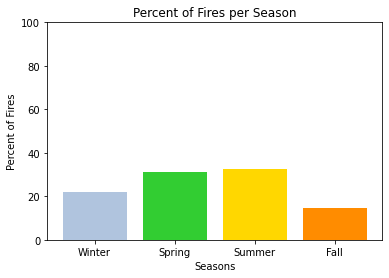

In [25]:
#Percent of fires per season
winter_fires = round(100*winter.shape[0]/df.shape[0],1)
spring_fires = round(100*spring.shape[0]/df.shape[0],1)
summer_fires = round(100*summer.shape[0]/df.shape[0],1)
fall_fires = round(100*fall.shape[0]/df.shape[0],1)

#plot fires / season
fig, ax = plt.subplots()
ax.bar(['Winter','Spring','Summer','Fall'], [winter_fires, spring_fires, summer_fires, fall_fires], 
       color = ['lightsteelblue','limegreen','gold','darkorange'])
ax.set_xlabel('Seasons')
ax.set_ylabel('Percent of Fires')
ax.set_ylim(0, 100)
ax.set_title('Percent of Fires per Season')
plt.show()

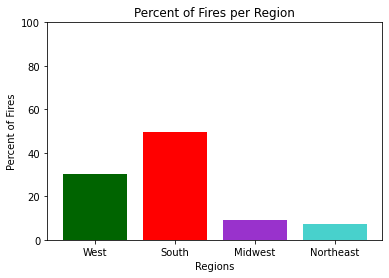

In [24]:
#Percent of fires per region
ne_fires = round(100*northeast_df.shape[0]/df.shape[0],1)
mw_fires = round(100*midwest_df.shape[0]/df.shape[0],1)
s_fires = round(100*south_df.shape[0]/df.shape[0],1)
w_fires = round(100*west_df.shape[0]/df.shape[0],1)

#plot fires / region
fig, ax = plt.subplots()
ax.bar(['West','South','Midwest','Northeast'], [w_fires, s_fires, mw_fires, ne_fires], 
       color = ['darkgreen','red','darkorchid','mediumturquoise'])
ax.set_xlabel('Regions')
ax.set_ylabel('Percent of Fires')
ax.set_ylim(0, 100)
ax.set_title('Percent of Fires per Region')
plt.show()

In [ ]:
#Percent of fires in NE per season
winter_in_ne = round(100*winter_ne.shape[0]/northeast_df.shape[0],1)
spring_in_ne = round(100*spring_ne.shape[0]/northeast_df.shape[0],1)
summer_in_ne = round(100*summer_ne.shape[0]/northeast_df.shape[0],1)
fall_in_ne = round(100*fall_ne.shape[0]/northeast_df.shape[0],1)
ne_season_fires = [winter_in_ne,spring_in_ne,summer_in_ne,fall_in_ne]

#Percent of fires in MW per season
winter_in_mw = round(100*winter_mw.shape[0]/midwest_df.shape[0],1)
spring_in_mw = round(100*spring_mw.shape[0]/midwest_df.shape[0],1)
summer_in_mw = round(100*summer_mw.shape[0]/midwest_df.shape[0],1)
fall_in_mw = round(100*fall_mw.shape[0]/midwest_df.shape[0],1)
mw_season_fires = [winter_in_mw,spring_in_mw,summer_in_mw,fall_in_mw]

#Percent of fires in S per season
winter_in_s = round(100*winter_s.shape[0]/south_df.shape[0],1)
spring_in_s = round(100*spring_s.shape[0]/south_df.shape[0],1)
summer_in_s = round(100*summer_s.shape[0]/south_df.shape[0],1)
fall_in_s = round(100*fall_s.shape[0]/south_df.shape[0],1)
s_season_fires = [winter_in_s,spring_in_s,summer_in_s,fall_in_s]

#Percent of fires in W per season
winter_in_w = round(100*winter_w.shape[0]/west_df.shape[0],1)
spring_in_w = round(100*spring_w.shape[0]/west_df.shape[0],1)
summer_in_w = round(100*summer_w.shape[0]/west_df.shape[0],1)
fall_in_w = round(100*fall_w.shape[0]/west_df.shape[0],1)
w_season_fires = [winter_in_w,spring_in_w,summer_in_w,fall_in_w]

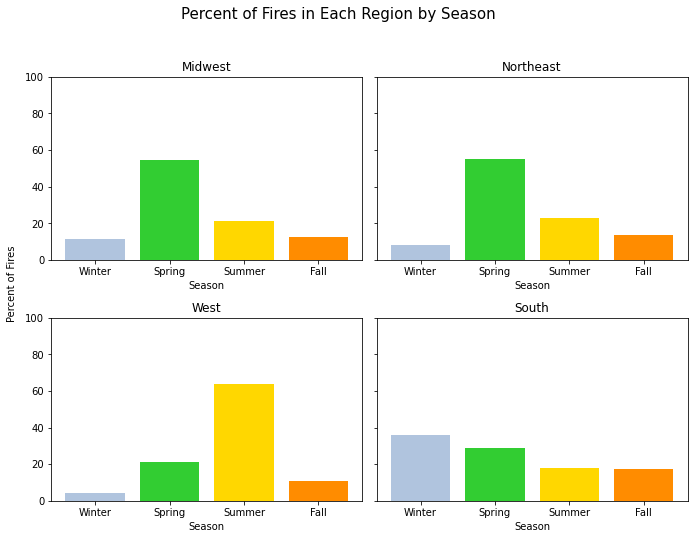

In [41]:
#plot all regions' seasonal frequencies onto same plot
seasons = ['Winter', 'Spring', 'Summer', 'Fall']
all_season_regions = [mw_season_fires,ne_season_fires,w_season_fires,s_season_fires]
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
sub_titles = ['Midwest','Northeast','West','South']
for ax, sub_title, region in zip(axs.flat, sub_titles, all_season_regions):
    ax.bar(['Winter', 'Spring', 'Summer', 'Fall'], region, color=['lightsteelblue','limegreen','gold','darkorange'])
    ax.set_title(sub_title)
    ax.set_ylim(0, 100)
    ax.set_xlabel('Season')
fig.text(0.04, 0.5, 'Percent of Fires', va='center', rotation='vertical')
fig.suptitle('Percent of Fires in Each Region by Season',size=15.0)
fig.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()

### Examine change in frequency over time / region, season, region+season

Text(0, 0.5, 'Number of Fires')

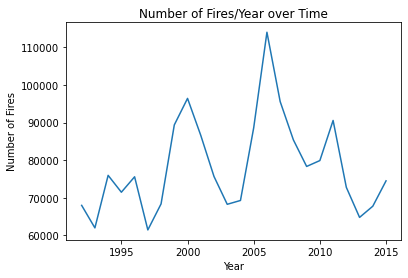

In [48]:
#df names: regionname_df, season, season_region
#get a frequency of fires/year, then plot
#24 years of data

df_years = df.groupby('FIRE_YEAR').count()
plt.plot(df_years.reset_index().get('FIRE_YEAR').to_numpy(), df_years.get('FOD_ID').to_numpy())
plt.title('Number of Fires/Year over Time')
plt.xlabel('Year')
plt.ylabel('Number of Fires')

Text(0, 0.5, 'Number of Fires')

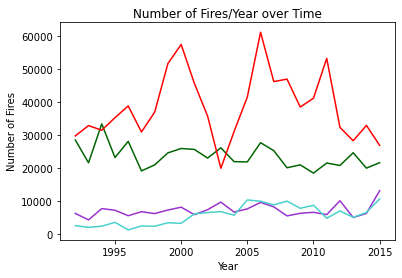

In [51]:
#fires/region over time
west_years = west_df.groupby('FIRE_YEAR').count()
south_years = south_df.groupby('FIRE_YEAR').count()
midwest_years = midwest_df.groupby('FIRE_YEAR').count()
northeast_years = northeast_df.groupby('FIRE_YEAR').count()

#plot all regions' change in frequency over time
plt.plot(west_years.reset_index().get('FIRE_YEAR').to_numpy(), west_years.get('FOD_ID').to_numpy(),color='darkgreen')
plt.plot(south_years.reset_index().get('FIRE_YEAR').to_numpy(), south_years.get('FOD_ID').to_numpy(),color='red')
plt.plot(midwest_years.reset_index().get('FIRE_YEAR').to_numpy(), midwest_years.get('FOD_ID').to_numpy(),color='darkorchid')
plt.plot(northeast_years.reset_index().get('FIRE_YEAR').to_numpy(), northeast_years.get('FOD_ID').to_numpy(),color='mediumturquoise')
plt.title('Number of Fires/Year over Time')
plt.xlabel('Year')
plt.ylabel('Number of Fires')